In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly_express as px
from IPython.display import display, HTML


In [2]:
sns.set()


In [5]:
import configparser
config = configparser.ConfigParser()
config.read("env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [7]:
data_prefix = 'entrepreneur'

In [26]:
novels_csv = f'{output_dir}/{data_prefix}-TOKEN.csv'
vocab_csv = f'{output_dir}/{data_prefix}-VOCAB-PARAS.csv'
lib_csv = f'{output_dir}/{data_prefix}-LIB-KEY.csv'
bow_csv = f'{output_dir}/{data_prefix}-BOW-PARAS.csv'

In [27]:
OHCO = ['screenplay_id', 'scene_id', 'para_num', 'sent_num', 'token_num']
SCREENPLAY = OHCO[:1]
SCENE = OHCO[:2]
PARAS = OHCO[:3]
SENTS = OHCO[:4]



In [28]:
salex_csv = 'salex_nrc.csv'
emo_cols = "anger anticipation disgust fear joy sadness surprise trust sentiment".split()

In [29]:
TOKENS = pd.read_csv(novels_csv).set_index(OHCO).sort_index()
VOCAB = pd.read_csv(vocab_csv).set_index('term_str').sort_index()
LIB = pd.read_csv(lib_csv).set_index('screenplay_id')[['title_key']].sort_index()
BOW = pd.read_csv(bow_csv).set_index(['screenplay_id','scene_id','term_str']).sort_index()

In [30]:
SALEX = pd.read_csv(salex_csv).set_index('term_str')
SALEX.columns = [col.replace('nrc_','') for col in SALEX.columns]


## VOCAB SENT

In [31]:
V = VOCAB.join(SALEX, how='inner')
V

,term_rank,n,n_chars,p,i,max_pos,max_pos_group,n_pos_group,cat_pos_group,n_pos,...,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,sentiment
term_str,,,,,,,,,,,,,,,,,,,,,
abandoned,2631,5,9,0.000033,14.877390,VBN,VB,VB,"{'VB', 'NN'}",3,...,0,0,1,0,1,0,1,0,0,-1
abject,8335,1,6,0.000007,17.199318,VBP,VB,VB,{'VB'},1,...,0,1,0,0,1,0,0,0,0,-1
absence,6403,2,7,0.000013,16.199318,NN,NN,NN,{'NN'},1,...,0,0,1,0,1,0,1,0,0,-1
abuse,8318,1,5,0.000007,17.199318,NN,NN,NN,{'NN'},1,...,0,1,1,0,1,0,1,0,0,-1
academic,8326,1,8,0.000007,17.199318,JJ,JJ,JJ,{'JJ'},1,...,0,0,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
worthless,2726,5,9,0.000033,14.877390,NN,NN,NN,"{'JJ', 'NN'}",3,...,0,1,0,0,1,0,1,0,0,-1
worthy,6578,1,6,0.000007,17.199318,JJ,JJ,JJ,{'JJ'},1,...,0,0,0,0,0,1,0,0,1,1
wound,3192,4,5,0.000027,15.199318,NN,NN,NN,"{'JJ', 'NN'}",2,...,0,0,1,0,1,0,1,0,0,-1


## BOW SENT

In [54]:
B = BOW.join(V[['max_pos'] + emo_cols], on='term_str', rsuffix='_v', how='inner') #.dropna()

In [55]:
for col in emo_cols:
    B[col] = B[col] * B.tfidf
B.head()

para_num  n        tf     tfidf max_pos  \
screenplay_id scene_id term_str                                             
joy           2        delicious         0  1  0.004149  0.035721      JJ   
                       demand            0  1  0.004149  0.041776      NN   
                       electric          0  1  0.004149  0.039349     NNP   
                       familiar          0  1  0.004149  0.031850      JJ   
                       good              0  1  0.004149  0.019509      JJ   

                                     anger  anticipation  disgust  fear  \
screenplay_id scene_id term_str                                           
joy           2        delicious  0.000000      0.000000      0.0   0.0   
                       demand     0.041776      0.000000      0.0   0.0   
                       electric   0.000000      0.000000      0.0   0.0   
                       familiar   0.000000      0.000000      0.0   0.0   
                       good       0.000000      0.019509      0.0   0.0   

                                       joy  sadness  surprise     trust  \
screenplay_id scene_id term_str                                           
joy           2        delicious  0.035721      0.0  0.000000  0.000000   
                       demand     0.000000      0.0  0.000000  0.000000   
                       electric   0.039349      0.0  0.039349  0.000000   
                       familiar   0.000000      0.0  0.000000  0.031850   
                       good       0.019509      0.0  0.019509  0.019509   

                                  sentiment  
screenplay_id scene_id term_str              
joy           2        delicious   0.035721  
                       demand     -0.041776  
                       electric    0.039349  
                       familiar    0.031850  
                       good        0.019509

## DOC SENT

In [56]:
B.columns

Index(['para_num', 'n', 'tf', 'tfidf', 'max_pos', 'anger', 'anticipation',
       'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust', 'sentiment'],
      dtype='object')

In [57]:
for col in ['anger', 'anticipation',
       'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust', 'sentiment']:
    B[f'{col}_tf'] = B['tf'] * B[col]

In [58]:
DOC_SENT = B.groupby(['screenplay_id', 'scene_id'])[
    [f'{col}_tf' for col in ['anger', 'anticipation',
       'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust', 'sentiment']]
].sum()

In [59]:
DOC_SENT

anger_tf  anticipation_tf  disgust_tf   fear_tf  \
screenplay_id      scene_id                                                    
joy                2         0.000301         0.000192    0.000000  0.000000   
                   4         0.015989         0.000000    0.015989  0.015989   
                   6         0.000000         0.010825    0.000000  0.010825   
                   9         0.000000         0.027712    0.000000  0.027712   
                   10        0.000000         0.000000    0.000000  0.000440   
...                               ...              ...         ...       ...   
the_social_network 569       0.000817         0.000000    0.000817  0.001175   
                   572       0.000655         0.001049    0.000655  0.001144   
                   573       0.000702         0.000781    0.000737  0.001341   
                   574       0.000171         0.000500    0.000171  0.000347   
                   575       0.002581         0.002570    0.002581  0.002581   

                               joy_tf  sadness_tf  surprise_tf  trust_tf  \
screenplay_id      scene_id                                                
joy                2         0.000392    0.000159     0.000244  0.000213   
                   4         0.000000    0.015989     0.000000  0.000000   
                   6         0.000000    0.000000     0.000000  0.000000   
                   9         0.029372    0.000000     0.000000  0.029372   
                   10        0.000000    0.000409     0.000000  0.000288   
...                               ...         ...          ...       ...   
the_social_network 569       0.000000    0.000817     0.000000  0.000000   
                   572       0.000314    0.000655     0.000804  0.000682   
                   573       0.000232    0.001075     0.000428  0.001126   
                   574       0.000257    0.000134     0.000000  0.000590   
                   575       0.000000    0.005107     0.000000  0.003304   

                             sentiment_tf  
screenplay_id      scene_id                
joy                2            -0.000047  
                   4            -0.015989  
                   6             0.000000  
                   9             0.029372  
                   10            0.000319  
...                                   ...  
the_social_network 569          -0.001175  
                   572          -0.000123  
                   573           0.000461  
                   574           0.000233  
                   575          -0.004372  

[1397 rows x 9 columns]

##  Sentiment Temporal Visualization

In [60]:
B = B.reset_index(['term_str'])
thesocialnetwork = B.loc['the_social_network'].copy()
joy = B.loc['joy'].copy()

In [62]:
emo = 'sentiment'



In [63]:

thesocialnetwork['html'] = thesocialnetwork.apply(lambda x: "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.term_str), 1)
joy['html'] =  joy.apply(lambda x: "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.term_str), 1)


     

In [64]:
thesocialnetwork[['html']].sample(10)

,html
scene_id,
141,<span class='sent-1'>row</span>
221,<span class='sent-1'>problem</span>
101,<span class='sent1'>flying</span>
473,<span class='sent1'>brother</span>
441,<span class='sent1'>cheering</span>
506,<span class='sent1'>gift</span>
341,<span class='sent-1'>punch</span>
566,<span class='sent1'>beautiful</span>
381,<span class='sent-1'>shit</span>


In [66]:
thesocialnetwork_sents = thesocialnetwork.groupby(SCENE[1:])[emo_cols].mean()
joy_sents = joy.groupby(SCENE[1:])[emo_cols].mean()

In [73]:
thesocialnetwork_sents['sent_str'] = thesocialnetwork.groupby(SCENE[1:]).term_str.apply(lambda x: ' '.join(map(str, x))) # For VADER below
thesocialnetwork['html_str'] = thesocialnetwork.groupby(SCENE[1:]).html.apply(lambda x: ' '.join(map(str, x)))


In [74]:
joy_sents['sent_str'] = joy.groupby(SCENE[1:]).term_str.apply(lambda x: ' '.join(map(str, x))) # For VADER below
joy['html_str'] = joy.groupby(SCENE[1:]).html.apply(lambda x: ' '.join(map(str, x)))

In [76]:
pip install vaderSentiment

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for vaderSentiment from https://files.pythonhosted.org/packages/76/fc/310e16254683c1ed35eeb97386986d6c00bc29df17ce280aed64d55537e9/vaderSentiment-3.3.2-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 10.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [77]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()


### THE SOCIAL NETWORK SENTIMENT TRACKER

In [78]:
tsn_vader_cols = thesocialnetwork_sents.sent_str.apply(analyser.polarity_scores).apply(lambda x: pd.Series(x))
tsn_vader = thesocialnetwork_sents.join(tsn_vader_cols)


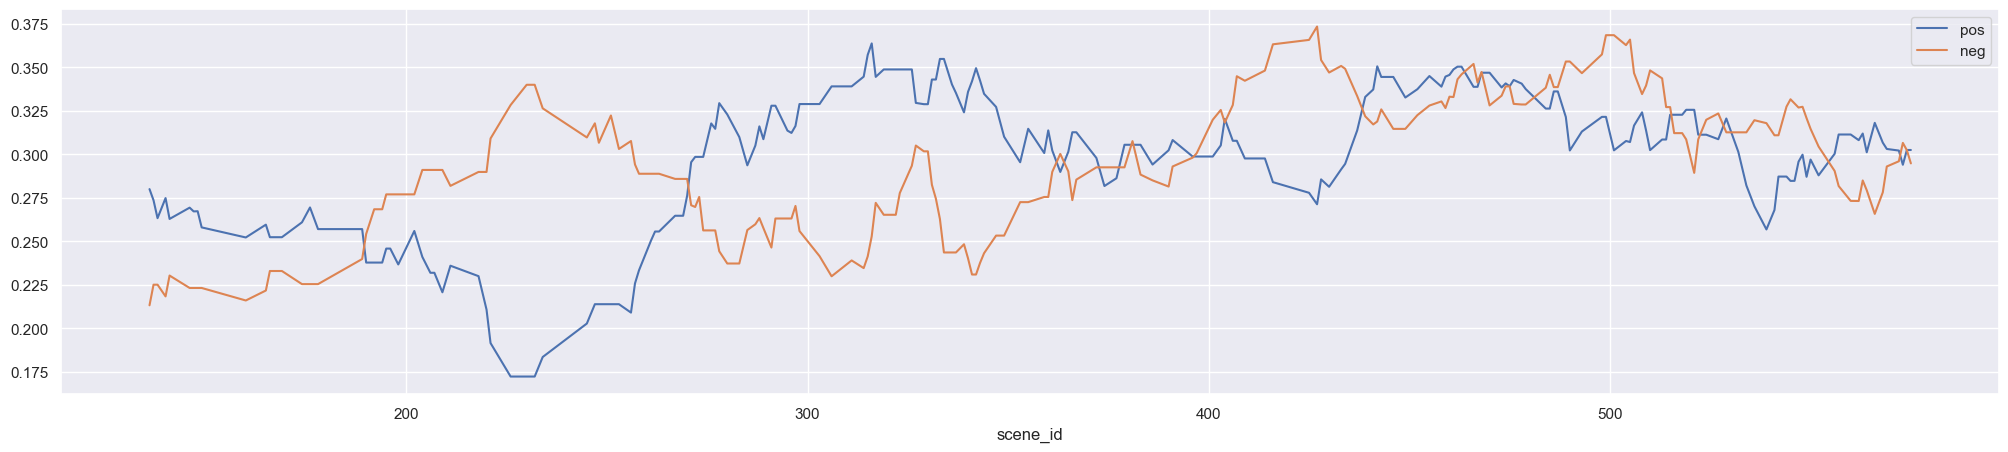

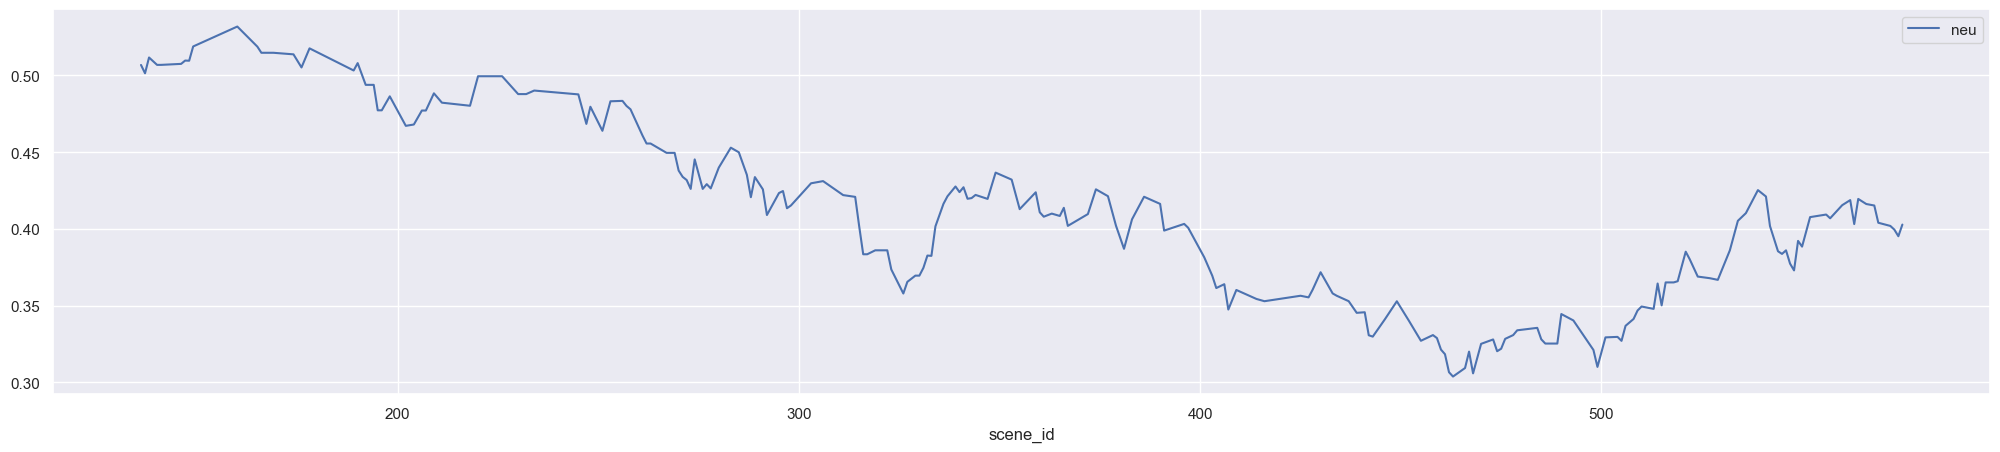

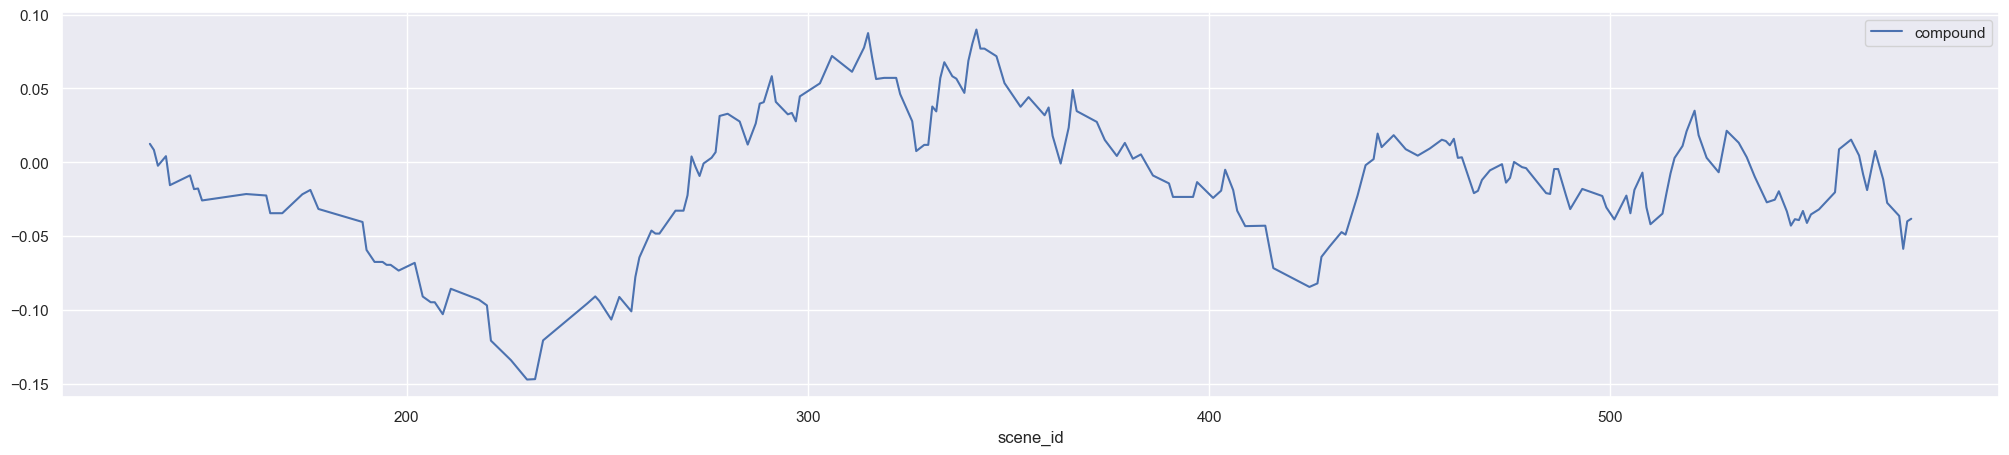

In [79]:
w = int(tsn_vader.shape[0] / 5)
tsn_vader[['pos','neg']].rolling(w).mean().plot(figsize=(25,5));
tsn_vader[['neu']].rolling(w).mean().plot(figsize=(25,5));
tsn_vader[['compound']].rolling(w).mean().plot(figsize=(25,5));


### JOY SENTIMENT TRACKER 

In [80]:
joy_vader_cols = joy_sents.sent_str.apply(analyser.polarity_scores).apply(lambda x: pd.Series(x))
joy_vader = joy_sents.join(joy_vader_cols)


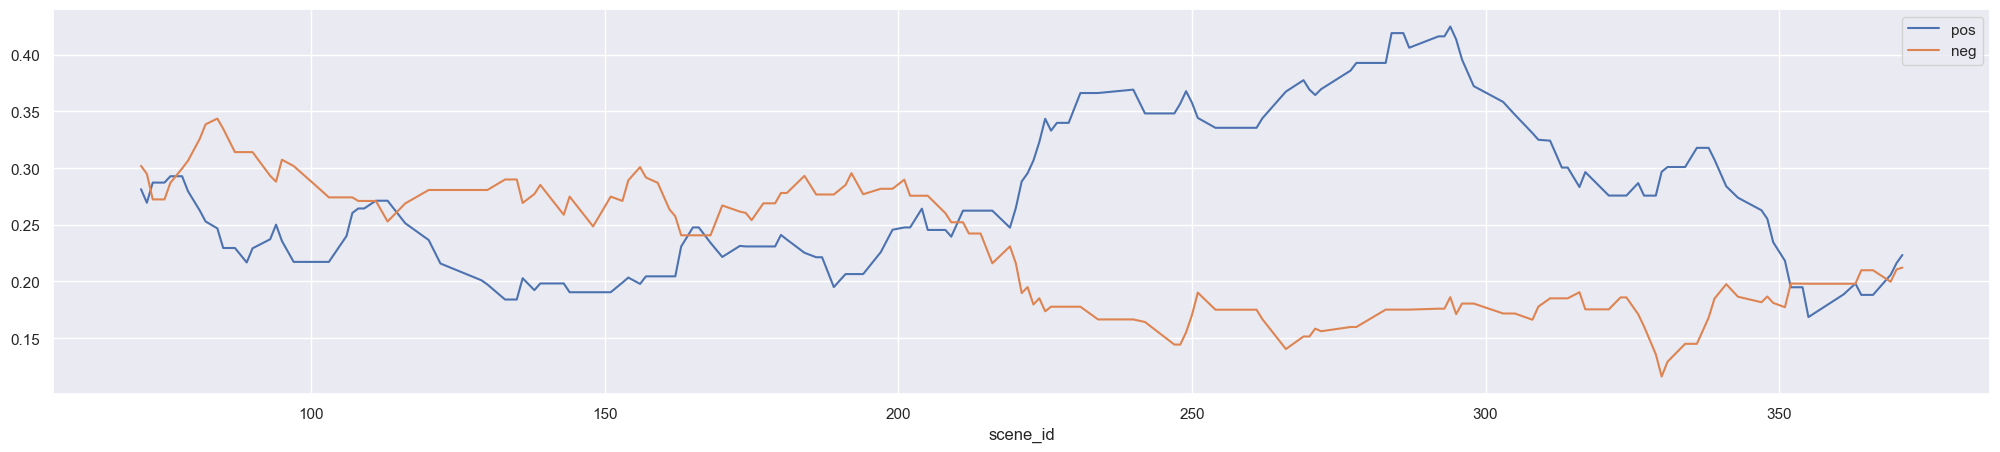

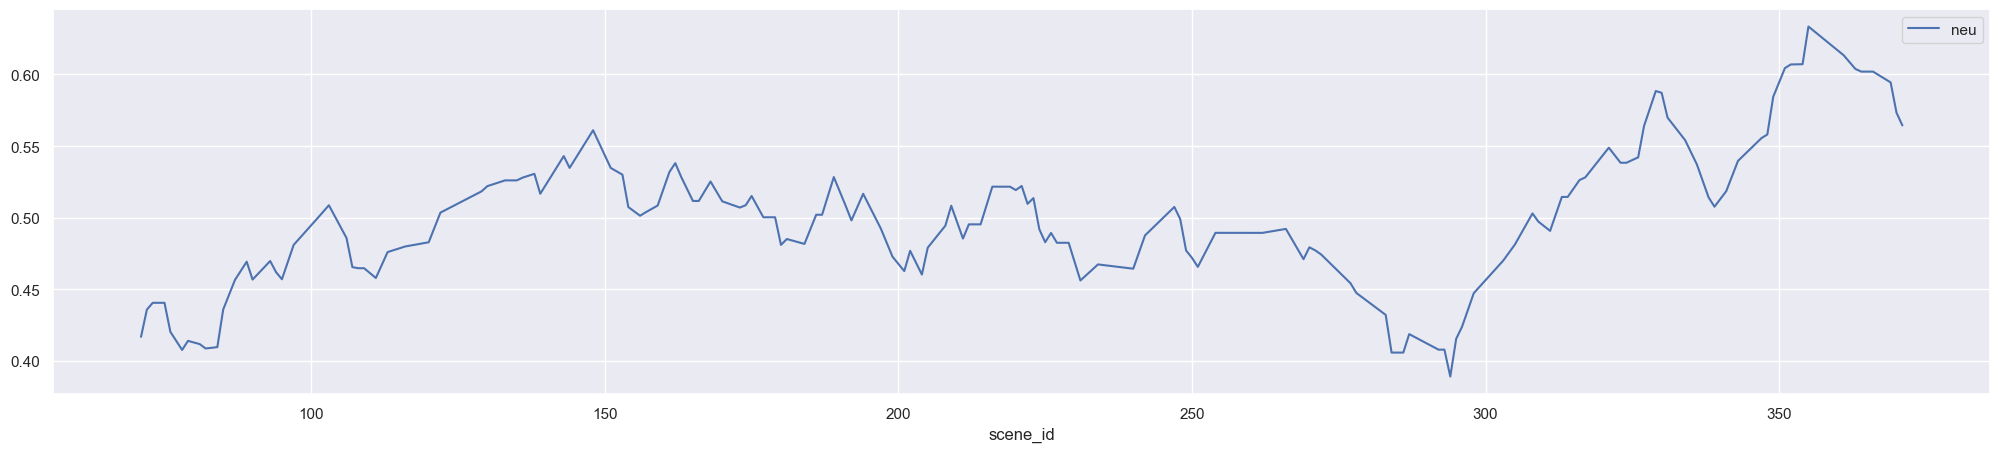

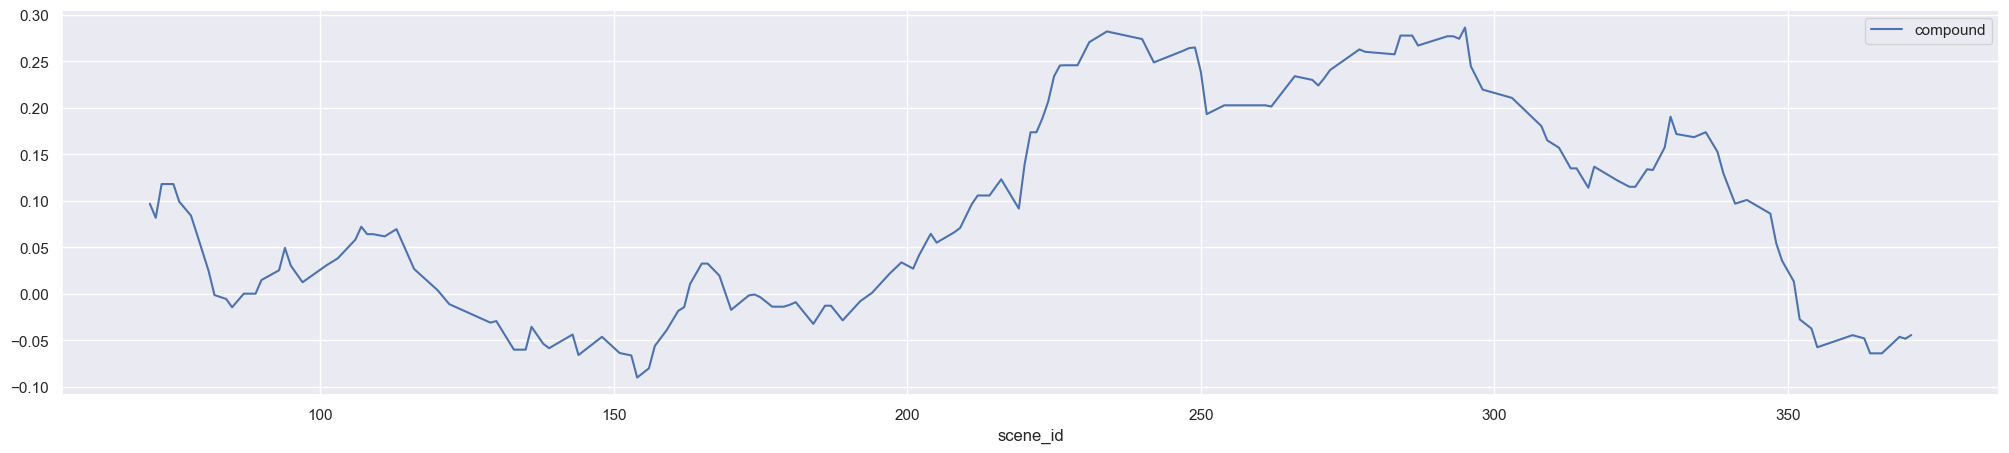

In [81]:
w = int(joy_vader.shape[0] / 5)
joy_vader[['pos','neg']].rolling(w).mean().plot(figsize=(25,5));
joy_vader[['neu']].rolling(w).mean().plot(figsize=(25,5));
joy_vader[['compound']].rolling(w).mean().plot(figsize=(25,5));
